In [1]:
import os
import pandas as pd
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score
import math
from numpy import mean
from numpy import std
from numpy import absolute
from numpy import cov
import numpy as np
import inspect
from sklearn.linear_model import LogisticRegression
from google.colab import drive
drive.mount('/content/drive')
import glob

from random import *
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/Project271B

/content/drive/MyDrive/Project271B


In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [62]:
file = tf.keras.utils
raw_df = pd.read_csv('dropped_df.csv')
raw_df.head()
raw_df = raw_df.loc[:, ~raw_df.columns.str.contains('^Unnamed')]

In [63]:
cleaned_df = raw_df

In [64]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.15)
train_df, val_df = train_test_split(train_df, test_size=0.15)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('TenYearCHD'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('TenYearCHD'))
test_labels = np.array(test_df.pop('TenYearCHD'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [65]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (2879,)
Validation labels shape: (509,)
Test labels shape: (599,)
Training features shape: (2879, 14)
Validation features shape: (509, 14)
Test features shape: (599, 14)


In [66]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [67]:
EPOCHS = 100
BATCH_SIZE = 64

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [68]:
model = make_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 16)                240       
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 17        
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


In [69]:
model.predict(train_features[:10])

1/1 [==============================] - 0s 46ms/step


array([[0.11969244],
       [0.12010742],
       [0.09985388],
       [0.13696   ],
       [0.08382278],
       [0.12600443],
       [0.031215  ],
       [0.05257114],
       [0.04631142],
       [0.23209848]], dtype=float32)

In [70]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.4973


In [71]:
model = make_model(output_bias=-1)
model.predict(train_features[:10])

1/1 [==============================] - 0s 44ms/step


array([[0.3395562 ],
       [0.23769131],
       [0.42624283],
       [0.26573685],
       [0.3449892 ],
       [0.29718956],
       [0.27650526],
       [0.23993959],
       [0.33166367],
       [0.35951066]], dtype=float32)

In [72]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.5446


In [73]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [74]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [75]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [76]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
              label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

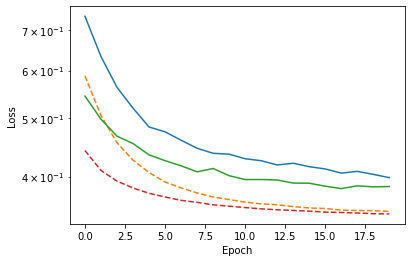

In [77]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [78]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
45/45 [==============================] - 3s 30ms/step - loss: 0.5470 - tp: 41.0000 - fp: 136.0000 - tn: 2766.0000 - fn: 445.0000 - accuracy: 0.8285 - precision: 0.2316 - recall: 0.0844 - auc: 0.4736 - prc: 0.1525 - val_loss: 0.4437 - val_tp: 1.0000 - val_fp: 2.0000 - val_tn: 446.0000 - val_fn: 60.0000 - val_accuracy: 0.8782 - val_precision: 0.3333 - val_recall: 0.0164 - val_auc: 0.4170 - val_prc: 0.1267
Epoch 2/100
45/45 [==============================] - 0s 9ms/step - loss: 0.4972 - tp: 25.0000 - fp: 91.0000 - tn: 2363.0000 - fn: 400.0000 - accuracy: 0.8295 - precision: 0.2155 - recall: 0.0588 - auc: 0.4927 - prc: 0.1643 - val_loss: 0.4112 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 447.0000 - val_fn: 61.0000 - val_accuracy: 0.8782 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4782 - val_prc: 0.1432
Epoch 3/100
45/45 [==============================] - 0s 4ms/step - loss: 0.4690 - tp: 24.0000 - fp: 60.0000 - tn: 2394.0000 - fn: 401.0000 - accuracy: 0

In [79]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
            linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [80]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

10/10 [==============================] - 0s 1ms/step


In [81]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.44798678159713745
tp :  0.0
fp :  0.0
tn :  490.0
fn :  109.0
accuracy :  0.818030059337616
precision :  0.0
recall :  0.0
auc :  0.6861168146133423
prc :  0.29594874382019043

Legitimate Transactions Detected (True Negatives):  490
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  109
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  109


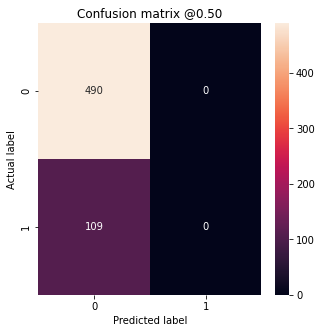

In [82]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [83]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  # plt.xlim([-0.5,20])
  # plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

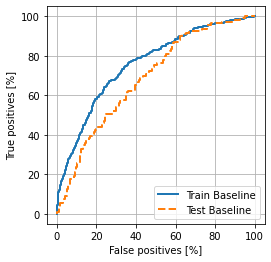

In [84]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline)
plot_roc("Test Baseline", test_labels, test_predictions_baseline, linestyle='--')
plt.legend(loc='lower right');

In [85]:
auc = metrics.roc_auc_score(train_labels,train_predictions_baseline)
print(auc)

0.7576595234670885


In [86]:

auc = metrics.roc_auc_score(test_labels, test_predictions_baseline)
print(auc)

0.6858453473132372


In [87]:
class_weight = {0: 3, 1: 5}

In [88]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100
45/45 [==============================] - 2s 16ms/step - loss: 2.1946 - tp: 31.0000 - fp: 190.0000 - tn: 2754.0000 - fn: 503.0000 - accuracy: 0.8007 - precision: 0.1403 - recall: 0.0581 - auc: 0.4618 - prc: 0.1445 - val_loss: 0.4535 - val_tp: 1.0000 - val_fp: 3.0000 - val_tn: 445.0000 - val_fn: 60.0000 - val_accuracy: 0.8762 - val_precision: 0.2500 - val_recall: 0.0164 - val_auc: 0.4234 - val_prc: 0.1303
Epoch 2/100
45/45 [==============================] - 0s 4ms/step - loss: 2.0061 - tp: 37.0000 - fp: 112.0000 - tn: 2342.0000 - fn: 388.0000 - accuracy: 0.8263 - precision: 0.2483 - recall: 0.0871 - auc: 0.5021 - prc: 0.1734 - val_loss: 0.4257 - val_tp: 2.0000 - val_fp: 2.0000 - val_tn: 446.0000 - val_fn: 59.0000 - val_accuracy: 0.8802 - val_precision: 0.5000 - val_recall: 0.0328 - val_auc: 0.5005 - val_prc: 0.1658
Epoch 3/100
45/45 [==============================] - 0s 5ms/step - loss: 1.8380 - tp: 61.0000 - fp: 108.0000 - tn: 2346.0000 - fn: 364.0000 - accuracy: 0.8361 - pr

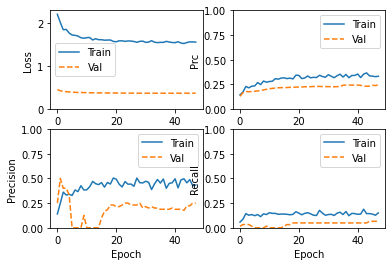

In [89]:
plot_metrics(weighted_history)


In [90]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

10/10 [==============================] - 0s 2ms/step


loss :  0.4440914988517761
tp :  6.0
fp :  9.0
tn :  481.0
fn :  103.0
accuracy :  0.813021719455719
precision :  0.4000000059604645
recall :  0.055045872926712036
auc :  0.6851806640625
prc :  0.29317742586135864

Legitimate Transactions Detected (True Negatives):  481
Legitimate Transactions Incorrectly Detected (False Positives):  9
Fraudulent Transactions Missed (False Negatives):  103
Fraudulent Transactions Detected (True Positives):  6
Total Fraudulent Transactions:  109


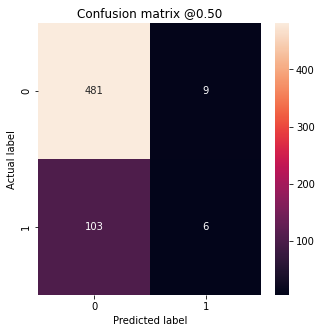

In [91]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

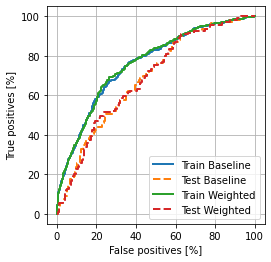

In [92]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline)
plot_roc("Test Baseline", test_labels, test_predictions_baseline, linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted)
plot_roc("Test Weighted", test_labels, test_predictions_weighted, linestyle='--')


plt.legend(loc='lower right');

In [93]:
auc = metrics.roc_auc_score(test_labels, test_predictions_weighted)
print(auc)

0.6855645010297696
